# Classify Drugs in Slang <a id='top'></a>

***

## Table of Contents

1. [Introduction](#intro)
2. [Data Preparation](#data-prep)
    1. [Load Data](#load-data)
    2. [Preprocess Data](#preprocess-data)
    3. [Clean Data](#clean-data)
    4. [Count Word Frequency](#freq-words)
3. [Train-Test Split](#split-cv)
4. [Bag-of-Words Model](#BoW)
    1. [Count Vectorizer](#CountVectorizer)
        1. [Naive Bayes](#nb)
        2. [Evaluation Metrics](#evaluate)
    2. [N-grams](#N-grams)
    3. [Term Frequency - Inverse Document Frequency (Tfidf)](#TfidfVectorizer)
    4. [Hashing Vectorizer](#HashingVectorizer)
5. [Cross Validation](#cross-val)
6. [Hyper-Parameter Tuning with Grid Search](#gridsearch)
7. [Pipelining](#pipe)
8. [Put everything in Feature Union](#union)
9. [Examine Grid Search Results](#results)
10. [Train Best Combinations & Plot Results](#plot-best)
11. [Optimize Best Model](#optim-best)
    1. [Most Important Features](#feats)
12. [Export Data](#export)

## Introduction <a id='intro'></a>

In this project, we will apply Natural Language Processing (NLP) using Python to identify and classify drugs in slang phrases. This NLP study will use Python NLTK library. NLTK is a popular Python library which is used for NLP.

NLP is about developing applications and services that are able to understand human languages. Practical examples of natural language processing (NLP) like speech recognition, speech translation, understanding complete sentences, understanding synonyms of matching words, and writing complete grammatically correct sentences and paragraphs.

About the dataset and the project goal:

* The dataset contains several words on Urban Dictionary of drugs slang. These are some of the terms scraped from the most common section, but there should be more in the future.
* There are 29 classes of drugs type that we need to classify these slangs into. However, since the classes are very imbalanced in the current data set and there is only a very small portion of the drug types slang in the data set, we will try to classify phrases into the following 5 classes:

    1. `1': Terms relevant to drugs
    2. `2`: Terms not relevant to drugs

[Go to the top](#top)

## Data Preparation <a id='data-prep'></a>

### Load Data <a id='load-data'></a>

Read the data into a `Pandas` dataframe using the `read_csv` function.

In [6]:
# Import the required libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, download_plotlyjs
import cufflinks as cf
import plotly.express as px
init_notebook_mode(connected=True)
cf.go_offline()

import re

from tqdm import tqdm

import time

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ngohi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ngohi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# Read the dataset.
dataset = pd.read_csv('urban-data.csv')

# Get the info of our dataset.
print(dataset.info())

# Show the first rows.
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   <empty_1>  2999 non-null   int64 
 1   Word       2999 non-null   object
 2   Example    2993 non-null   object
 3   Class      2999 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 93.8+ KB
None


,<empty_1>,Word,Example,Class
0,1,party,n. a social atmosphere that includes mixin' an...,1
1,2,bud,marajuana,1
2,3,junk,the stuff that you leave lying around on your ...,1
3,4,faded,piss drunk!,1
4,5,BYOC,Acronym: Bring Your Own Crap. Similar to [BYOB...,1


[Go to the top](#top)

### Preprocess Data <a id='preprocess-data'></a>


Once we look carefully at our data, we can find two problems:

1. Target variable `Class` is text and should be transformed to number. Most machine learning models require numbers in order to work without errors. The easiest way is to convert the numerical type to categorical.
2. Our dataset suffers from order. It is very important that our dataset is shuffled well to avoid any element of bias/patterns in the split datasets before training the machine learning models.

In [8]:

# The frac keyword argument specifies the fraction of rows to return in the random sample,
# so frac=1 means return all rows (in random order).
# To shuffle the dataframe in-place and reset the index,
# specify drop=True to prevent .reset_index
# from creating a column containing the old index entries.
dataset = dataset.sample(frac=1, random_state=5).reset_index(drop=True)

# Encode object 'Class' to categorical.
dataset['Class'] = dataset['Class'].astype('category')

# Show the first rows.
dataset.head()

,<empty_1>,Word,Example,Class
0,2430,slizzard,A gentler 'krunk'. Probably a result of too mu...,2
1,2387,around,a hoe that been wit too many dudes,2
2,1966,who`,just a fun lil pal.,2
3,1699,nonnock,A bizarre insult that doesn't have any particu...,2
4,1201,cootchie cutter,Pants or shorts that fit tightly across one's ...,2


[Go to the top](#top)

### Clean Data <a id='clean-data'></a>

The following 3 important steps will be implemented:

1. Lower-casing: The entire text will be converted into lower case, so that captialization is ignored (e.g., IndIcaTE is treated the same as Indicate).
2. Normalizing Numbers: All numbers will be replaced with the text “number”.
3. Removal of non-words and of punctuation: Non-words and punctuation will be removed. All white spaces (tabs, newlines, spaces) will all be trimmed to a single space character.
4. Tokenization: Tokenization is the act of breaking up a sequence of strings into pieces such as words, keywords, phrases, symbols and other elements called tokens. Tokens can be individual words, phrases or even whole sentences. In the process of tokenization, some characters like punctuation marks are discarded. The tokens become the input for another process like parsing and text mining. Then the words will be ready to be encoded as integers or floating point values for use as input to a machine learning algorithms, called feature extraction (or vectorization).
5. Word Stemming: Words are reduced to their stemmed form. For example, “discount”, “discounts”, “discounted” and “discounting” will be all replaced with “discount”. Sometimes, the Stemmer actually strips off additional characters from the end, so “include”, “includes”, “included”, and “including” are all replaced with “includ”.
6. Remove StopWords: Stop words are so frequently used that for many tasks (but not all), they don't carry much information. Examples are "any", "all", "what"... NLTK has an inbuilt corpus of english stopwords that can be loaded and used. Using that corpus, create a list of english stopwords.
7. Additional text preparation steps, such as Normalizing Links and Emails: All https and http links will be replaced with the text "link" and all emails will be replaced with the text "email".

In [9]:
# Create and register a new 'tqdm' instance with Pandas.
tqdm.pandas()

# Create a function to clean and prepare text.
def preproces_text(slang):
    """ Remove any punctuation, numbers, newlines, and stopwords.
    Convert to lower case.
    Split the text string into individual words, stem each word,
    and append the stemmed word to words. Make sure there's a single
    space between each stemmed word.
    Args:
        slang: the text of slang phrase, string
    Returns:
        words: the cleaned text, string
    """
    
    # Remove numbers.
    slang = re.sub('\d+', ' ', str(slang))
    
    # Replace newlines with spaces.
    slang = re.sub('\n', ' ', slang)
    
    # Replace punctuation with spaces.
    slang = re.sub(r'[^\w\s]', ' ', slang)
    
    # Replace links.
    slang = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
                   'link', str(slang), flags=re.MULTILINE)

    # Replace emails.
    slang = re.sub('\S+@\S+', 'email', slang, flags=re.MULTILINE)
    
    # Convert all letters to lower case.
    slang = slang.lower()
    
    # Tokenizing text.
    words = ''
    
    # Create the stemmer.
    stemmer = SnowballStemmer("english")
    
    # Split text into words.
    slang = slang.split()
    
    for word in slang:
        # Remove stopwords.
        if word not in set(stopwords.words('english')):
            # Stem word.
            words = words + stemmer.stem(word) + " "
    
    return words

# Apply the cleaning function to the dataset.
dataset['Example'] = dataset['Example'].progress_apply(preproces_text)

100%|██████████| 2999/2999 [00:10<00:00, 294.09it/s]


In [10]:
# Output a sample review of the cleaned text.
dataset.Example.iloc[53]

'often use describ extrem aggress punch action one person anoth fight '

[Go to the top](#top)

### Count Word Frequency <a id='freq-words'></a>

Find the most-used words in our slang and count how often they are used.

use                  347
one                  247
person               205
someon               189
someth               168
word                 148
sex                  133
term                 133
see                  129
n                    122
also                 112
like                 111
get                  99
usual                98
fuck                 94
slang                85
ass                  82
femal                78
mean                 76
act                  76


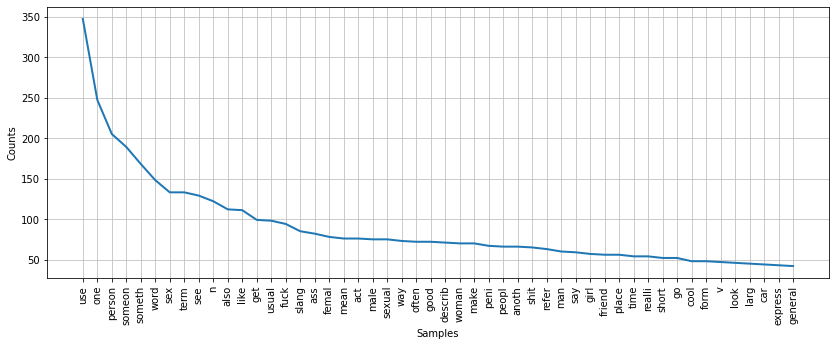

In [23]:
# Calculate the frequency distribution.
words = nltk.tokenize.word_tokenize(dataset['Example'].str.cat(sep=' '))
fdist = nltk.FreqDist(words)

# Output top 20 words.
for word, frequency in fdist.most_common(20):
    print('{0:20s} {1:d}'.format(word, frequency))

# Plot the frequency of 50 words.
plt.figure(figsize=(14, 5))
fdist.plot(50)

[Go to the top](#top)

## Train-Test Split <a id='split-cv'></a>

Split the dataset into training and test sets. The shuffle parameter is applied to `shuffle` the data before splitting. The `stratify` parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify. For example, if variable y is a binary categorical variable with values 0 and 1 and there are 20% of zeros and 80% of ones, `stratify=y` will make sure that the random split has 20% of 0's and 80% of 1's.

In [22]:
# Define X and y.
X = dataset.Example
y = dataset.Class

# Split the dataset into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20,
                                                    random_state = 0,
                                                    shuffle = True,
                                                    stratify = y)

[Go to the top](#top)

## Bag-of-Words Model <a id='BoW'></a>

We cannot work with text directly when using machine learning algorithms. Instead, we need to convert the text to numbers. Algorithms take vectors of numbers as input, therefore we need to convert documents to fixed-length vectors of numbers. A simple and effective model for thinking about text documents in machine learning is called the Bag-of-Words Model, or BoW.

The model is simple in that it throws away all of the order information in the words and focuses on the occurrence of words in a document. This can be done by assigning each word a unique number. Then, any document we see can be encoded as a fixed-length vector with the length of the vocabulary of known words. The value in each position in the vector could be filled with a count or frequency of each word in the encoded document.

This is the bag of words model, where we are only concerned with encoding schemes that represent what words are present or the degree to which they are present in encoded documents without any information about order.

There are many ways to extend this simple method, both by better clarifying what a “word” is and in defining what to encode about each word in the vector.

The `scikit-learn` library provides 3 different schemes to train our model and compare the performance:

1. `CountVectorizer`
2. `TfidfVectorizer`
3. `HashingVectorizer`

### Count Vectorizer <a id='CountVectorizer'></a>

The `CountVectorizer` provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document. Because these vectors will contain a lot of zeros, we call them sparse.

Many of the previous manual cleaning can be implemented with `CountVectorizer` automatically, but we have better control and more options when we do it manually.

In [21]:
# Create a default vectorizer.
default_vectorizer = CountVectorizer()

# Tokenize and build vocabulary to the train set.
X_train = default_vectorizer.fit_transform(X_train).toarray()

# Tokenize and build vocabulary to the test set.
X_test = default_vectorizer.transform(X_test).toarray()

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

[Go to the top](#top)

#### Naive Bayes <a id='nb'></a>

Fit the Naive Bayes classifier to the training set.

In [9]:
# Create the classifier.
nb = GaussianNB()

# Fit to the training set.
nb.fit(X_train, y_train)

GaussianNB()

[Go to the top](#top)

#### Evaluation Metrics <a id='evaluate'></a>

Evaluating a machine learning algorithm is an essential part of any project. A model may give satisfying results when evaluated using accuracy, but may give poor results when evaluated against other metrics such as recall or precision. Some of the different types of evaluation metrics available are:

* Accuracy: This is the ratio of number of correct predictions to the total number of input samples. However, the fraction of correct predictions is typically not enough information to evaluate a model. Although it is a starting point, it can lead to invalid decisions. Models with high accuracy may have inadequate precision or recall scores.

* Precision: This is the number of correct positive results divided by the number of positive results predicted by the classifier. In other words, this is the ability of the classifier not to label as positive a sample that is negative. The best value is $1$ and the worst value is $0$.

* Recall: This is the number of correct positive results divided by the number of all relevant samples (all samples that should have been identified as positive). In other words, this is the ability of the classifier to find all the positive samples. The best value is $1$ and the worst value is $0$.

* F1 Score: This is the Harmonic Mean (a weighted average) between precision and recall. The range for F1 Score is [0, 1]. This scores tells how precise a classifier is (how many instances it classifies correctly), as well as how robust it is (it does not miss a significant number of instances). High precision but lower recall, gives an extremely accurate prediction, but it then misses a large number of instances that are difficult to classify. The greater the F1 Score, the better is the performance of our model. The formula for the F1 score is:

$$F1 = 2 \times \frac{precision \times recall}{precision + recall}$$

**Note:** Some metrics are essentially defined for binary classification tasks (e.g. f1_score, roc_auc_score). In extending a binary metric to multiclass or multilabel problems, the data is treated as a collection of binary problems, one for each class. For more look at sklearn [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#average)


Confusion matrix, without normalization
[[  5   5]
 [ 22 568]]

Normalized confusion matrix
[[0.5        0.5       ]
 [0.03728814 0.96271186]]


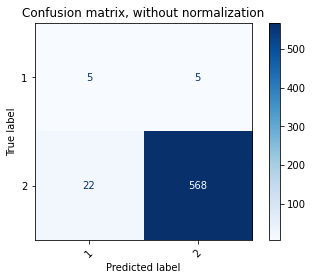

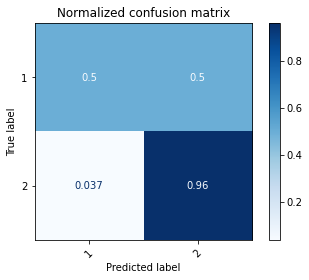



Precision scores for each object:
 [0.18518519 0.991274  ]

Mean precision score:
 0.5882295908473919


Recall scores for each object:
 [0.5        0.96271186]

Mean recall score:
 0.7313559322033898


F1 scores for each object:
 [0.27027027 0.97678418]

Mean F1 score:
 0.6235272245590389


In [10]:
# Create a function to evaluate the performance of the classifiers.
def eval_clf(classifier):
    # Make predictions.
    y_pred = classifier.predict(X_test)

    # Plot normalized and non-normalized confusion matrix.
    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, X_test, y_test,
                                     cmap=plt.cm.Blues,
                                     xticks_rotation=45,
                                     normalize=normalize)
        disp.ax_.set_title(title)
        print()
        print(title)
        print(disp.confusion_matrix)

    plt.show()

    # Generate evaluation metrics.
    cm = confusion_matrix(y_test, y_pred)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    f1 = 2 * precision * recall / (precision + recall)

    # Print results.
    print('\n')
    print('Precision scores for each object:\n', precision)
    print('\nMean precision score:\n', precision.mean())
    print('\n')
    print('Recall scores for each object:\n', recall)
    print('\nMean recall score:\n', recall.mean())
    print('\n')
    print('F1 scores for each object:\n', f1)
    print('\nMean F1 score:\n', f1.mean())

# Evaluate Naive Bayes with the default Count Vectorizer model.
eval_clf(nb)

**NOTES:**

* There are many misclassifications for most of the classes. This is due to the lack of training examples.

[Go to the top](#top)

### N-grams <a id='N-grams'></a>

A N-gram is a combination of N number of words treated as a single feature, as opposed to single word features in the Bag of Word. The idea is to extract contextual information and enrich data. For example the word "good" is always positive individually but can be negative when preceeded by "not". In certain cases, "not good" is an informative bigram.
N-grams can also be extracted through sklearn's CountVectorizer, but with a specific parameter. Find out how that parameter works and initiate a Bigram (2-gram) vectorizer.


Confusion matrix, without normalization
[[  9   1]
 [350 240]]

Normalized confusion matrix
[[0.9        0.1       ]
 [0.59322034 0.40677966]]


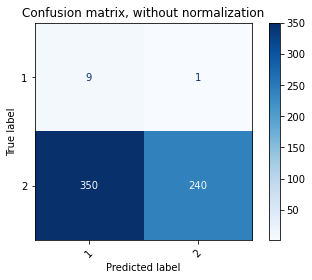

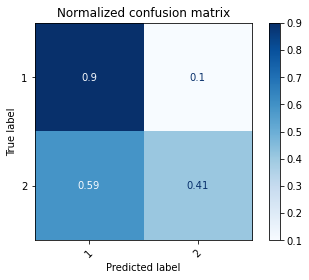



Precision scores for each object:
 [0.02506964 0.99585062]

Mean precision score:
 0.5104601301448237


Recall scores for each object:
 [0.9        0.40677966]

Mean recall score:
 0.6533898305084747


F1 scores for each object:
 [0.04878049 0.57761733]

Mean F1 score:
 0.31319890816236684


In [11]:
# Create a bigram vectorizer.
bigram_vec = CountVectorizer(ngram_range=(2, 2))

# Split the dataset into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20,
                                                    random_state = 0,
                                                    shuffle = True,
                                                    stratify = y)

# Tokenize and build vocabulary to the train set.
X_train = bigram_vec.fit_transform(X_train).toarray()

# Tokenize and build vocabulary to the test set.
X_test = bigram_vec.transform(X_test).toarray()

# Fit Naive Bayes to the training set.
nb = GaussianNB()
nb.fit(X_train, y_train)

# Evaluate Naive Bayes with a Bigram Count Vectorizer model.
eval_clf(nb)

[Go to the top](#top)

### Term Frequency - Inverse Document Frequency (Tfidf) <a id='TfidfVectorizer'></a>

Count vectorizer just counts the word frequencies. Simple as that. An alternative is to calculate word frequencies, and by far the most popular method is called TF-IDF. This is an acronym than stands for “Term Frequency – Inverse Document” Frequency, which are the components of the resulting scores assigned to each word:

* TF(t), i.e. Term Frequency: This summarizes how often a given word appears within a document = (Number of times term t appears in a document) / (Total number of terms in the document)



* IDF(t), i.e. Inverse Document Frequency: This downscales words that appear a lot across documents = log_e(Total number of documents / Number of documents with term t in it)


TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.

In other words, rather than counting occurences, the TfIdf vectorizer computes an importance value for each word in its text and according the entire corpus. That value is the product of the TF and the IDF.


Confusion matrix, without normalization
[[  5   5]
 [ 25 565]]

Normalized confusion matrix
[[0.5        0.5       ]
 [0.04237288 0.95762712]]


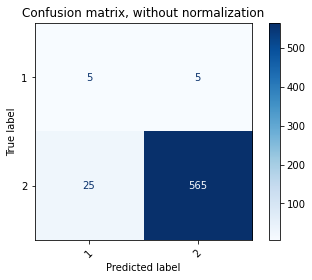

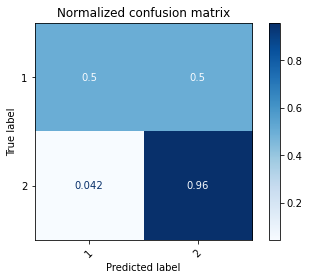



Precision scores for each object:
 [0.16666667 0.99122807]

Mean precision score:
 0.5789473684210527


Recall scores for each object:
 [0.5        0.95762712]

Mean recall score:
 0.728813559322034


F1 scores for each object:
 [0.25       0.97413793]

Mean F1 score:
 0.6120689655172413


In [12]:
# Create the TF-IDF Vectorizer.
tfidf_vec = TfidfVectorizer(sublinear_tf=True,
                            max_df=0.5, # Ignoring terms that appear in more than 50% of the documents.
                            stop_words='english')

# Split the dataset into the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20,
                                                    random_state = 0,
                                                    shuffle = True,
                                                    stratify = y)

# Tokenize and build vocabulary to the train set.
X_train = tfidf_vec.fit_transform(X_train).toarray()

# Tokenize and build vocabulary to the test set.
X_test = tfidf_vec.transform(X_test).toarray()

# Fit Naive Bayes to the training set.
nb = GaussianNB()
nb.fit(X_train, y_train)

# Evaluate Naive Bayes with the TF-IDF Vectorizer model.
eval_clf(nb)

**NOTES:**

It seems that `TfidfVectorizer` performed better than `CountVectorizer` in our case.

Let's find how many different words the TF-IDF model produced.

In [13]:
feature_names = tfidf_vec.get_feature_names()
print("Number of different words: {0}".format(len(feature_names)))
print("Word example: {0}".format(feature_names[3]))

Number of different words: 4542
Word example: abadi


In [25]:
import torch
print(torch.__version__)

ModuleNotFoundError: No module named 'torch'

[Go to the top](#top)

### Hashing Vectorizer <a id='HashingVectorizer'></a>

Counts and frequencies can be very useful, but one limitation of these methods is that the vocabulary can become very large. This, in turn, will require large vectors for encoding documents and impose large requirements on memory and slow down algorithms.

A clever work around is to use a one way hash of words to convert them to integers. The clever part is that no vocabulary is required and you can choose an arbitrary-long fixed length vector. A downside is that the hash is a one-way function so there is no way to convert the encoding back to a word (which may not matter for many supervised learning tasks).

In [14]:
# Create the Hashing Vectorizer.
hv_vec = HashingVectorizer()

# Split the dataset into the training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20,
                                                    random_state = 0,
                                                    shuffle = True,
                                                    stratify = y)

# Tokenize and build vocabulary to the train set.
X_train = hv_vec.fit_transform(X_train).toarray()

# Tokenize and build vocabulary to the test set.
X_test = hv_vec.transform(X_test).toarray()

# Fit Naive Bayes to the training set.
nb = GaussianNB()
nb.fit(X_train, y_train)

# Evaluate Naive Bayes with the Hashing Vectorizer model.
eval_clf(nb)

MemoryError: Unable to allocate 18.7 GiB for an array with shape (2399, 1048576) and data type float64

**NOTES:**

* We get poor performance again for the most of the classes.
* It seems that `TfidfVectorizer` performs slightly better in our case, since there are some significant/important words like "acid" that makes the difference for the classification. Term Frequency - Inverse Document Frequency (Tfidf) model can identify those words better than the other models. This model will be examined in more detail next.

[Go to the top](#top)

## Cross Validation <a id='cross-val'></a>

A common mistake is to learn the parameters of a prediction algorithm and testing it on the same data. What's wrong with that? We cannot fit the model to our training data and hope it would accurately work for the real data it has never seen before.

To avoid this to happen, there are several techniques: we could remove a part of the training data and using it to get predictions from the model trained on rest of the data (= Holdout Method). But, by reducing the training data, we risk losing patterns in data set and increase the error. The k-fold cross validation will help us to solve this problem.

In k-fold [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html), we split our data into k separated "folds". Then, the Holdout Method is repeated k times, such as each time, one of the k folds will be the test subset and the (k-1) other folds will be used together as the training set. In our multi-class case, we will use a variation of k-fold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

If the original data comes in some sort of sorted shape, a shuffle of the order of the data points is necessary before splitting them up into folds. This can be done in `KFold()`, setting the `shuffle` parameter to `True`. If there are concerns about class imbalance, then the `StratifiedKFold()` class should be used instead. Where `KFold()` assigns points to folds without attention to output class, `StratifiedKFold()` assigns data points to folds so that each fold has approximately the same number of data points of each output class. This is most useful for when we have imbalanced numbers of data points in the outcome classes (e.g. one is rare compared to the others). For this class as well, it can be used `shuffle=True` to shuffle the data points’ order before splitting into folds.

The general workflow to apply the Cross Validation is always the same:

1. Instanciate the model from scikit-learn.
2. Instanciate the `StratifiedKFold()` class with the parameters we want.
3. Use the `cross_val_score()` function to measure the performance of the model.

## Hyper-Parameter Tuning with Grid Search <a id='gridsearch'></a>

One of the most common reasons to do cross validation is to fine tune hyper-parameters. Hyper-parameters are set by the programmer whereas parameters are generated by the model. Most of the learning algorithms require some parameters tuning. It could be the number of trees in Gradient Boosting classifier, hidden layer size or activation functions in a Neural Network, type of kernel in an SVM and many more. We want to find the best parameters for our problem. We do it by trying different values and choosing the best ones. There are many methods to do this. It could be a manual search, a grid search or some more sophisticated optimization. However, in all those cases we can’t do it on our training test and not on our test set of course. We have to use a third set, a validation set.

Grid searching is the process of testing different parameter values for a model and selecting the ones that produce the best results. The steps are:

1. Load data.
2. Make a parameter dictionary.
3. Initiate a GridSearch algorithm.
4. GridSearch the data.
5. Print the results.

## Pipelining <a id='pipe'></a>

There are many steps required for building a machine learning model. In the case of NLP, the preprocessed text is vectorized, the vectorized data applied to a machine learning model that itself needs to have its parameters grid searched for optimization. A beautiful mess if you need to code it all one after the other, try out different vectorizers or different model parameters. Luckily, Sklearn's `Pipeline` package combines and simplifies it all!

[Go to the top](#top)

## Put everything in Feature Union <a id='union'></a>

`FeatureUnion` combines several transformer objects into a new transformer that combines their output. A `FeatureUnion` takes a list of transformer objects. During fitting, each of these is fit to the data independently. For transforming data, the transformers are applied in parallel, and the sample vectors they output are concatenated end-to-end into larger vectors.

**Notes:**

- Since, this task requires a vast amount of time, let's keep it simple and search only a few hyper-parameters. Later, when we find the best classifier, we can search more thorougly the hyper-parameters.
- Not all scoring methods support multi-class problems. For example, precision is is restricted to a binary classification task. In our case, we will use the weighted f1 evaluation method, which calculates metrics for each label, and finds their average weighted by support (the number of true instances for each label).

In [ ]:
# Set the random_state so we get the same values.
RS = 5

# Split the dataset into the training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20,
                                                    random_state = 0,
                                                    shuffle = True,
                                                    stratify = y)

# Create the pipeline object and initialize it with some models.
pipe = Pipeline([('vec', TfidfVectorizer()),
                 ('clf', LogisticRegression())])

# Create a list of candidate classifiers with their hyper-parameters for grid search.
search_space = [{'vec': [TfidfVectorizer(sublinear_tf=True, stop_words='english')],
                 'vec__max_df': [0.2, 0.5, 0.7, 0.9],
                 'vec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                 'clf': [LogisticRegression(n_jobs=-1, random_state=RS)],
                 'clf__C': [1.0, 5.0]
                },
                {'vec': [TfidfVectorizer(sublinear_tf=True, stop_words='english')],
                 'vec__max_df': [0.2, 0.5, 0.7, 0.9],
                 'vec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                 'clf': [SVC(random_state=RS, probability=True)],
                 'clf__C': [1.0, 10.0]
                },
                {'vec': [TfidfVectorizer(sublinear_tf=True, stop_words='english')],
                 'vec__max_df': [0.2, 0.5, 0.7, 0.9],
                 'vec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                 'clf': [KNeighborsClassifier(n_jobs=-1)],
                 'clf__n_neighbors': [3, 5]
                },
                {'vec': [TfidfVectorizer(sublinear_tf=True, stop_words='english')],
                 'vec__max_df': [0.2, 0.5, 0.7, 0.9],
                 'vec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                 'clf': [DecisionTreeClassifier(random_state=RS)],
                 'clf__min_samples_leaf': [1, 5]
                },
                {'vec': [TfidfVectorizer(sublinear_tf=True, stop_words='english')],
                 'vec__max_df': [0.2, 0.5, 0.7, 0.9],
                 'vec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                 'clf': [ExtraTreesClassifier(n_jobs=-1, random_state=RS)],
                 'clf__n_estimators': [10, 100]
                },
                {'vec': [TfidfVectorizer(sublinear_tf=True, stop_words='english')],
                 'vec__max_df': [0.2, 0.5, 0.7, 0.9],
                 'vec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                 'clf': [AdaBoostClassifier(random_state=RS)],
                 'clf__n_estimators': [10, 50]}]

# Create the grid search object.
gridsearch = GridSearchCV(pipe, param_grid=search_space, scoring='roc_auc_ovr_weighted',
                          cv=5, verbose=3, n_jobs=-1)

# Fit grid search.
best_model = gridsearch.fit(X_train, y_train)

print(best_model.best_estimator_)
print( "\nBest score:", best_model.best_score_)
print( "\nBest parameters:", best_model.best_params_)

[Go to the top](#top)

## Examine Grid Search Results <a id='results'></a>

Let's visualize the scores of all the combinations tested previously using `GridSearchCV`. We will sort the models by the best score. We can get valuable information with statistics of training times and scores.

In [ ]:
# Convert the dictionary of all the combinations from the gridsearch to a Pandas df to visualize it properly.
score_results = pd.DataFrame(best_model.cv_results_)

# Sort by best model first.
score_results.sort_values(by='rank_test_score')

[Go to the top](#top)

## Train Best Combinations & Plot Results <a id='plot-best'></a>

We will train again the best combinations of the previous models and then plot the scores as box plots to check visually the variance between k-fold results. For this case, let's make an assumption that the best hyper-parameters of the `TfidfVectorizer` model are `max_df= 0.2` and `ngram_range = (1, 1)`.

In [ ]:
# Split the dataset into the training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20,
                                                    random_state = 0,
                                                    shuffle = True,
                                                    stratify = y)

# Create the TF-IDF Vectorizer.
tfidf_vec = TfidfVectorizer(sublinear_tf=True,
                            ngram_range = (1, 1),
                            max_df=0.2, # Ignoring terms that appear in more than 50% of the documents.
                            stop_words='english')

# Tokenize and build vocabulary to the train set.
X_train = tfidf_vec.fit_transform(X_train)

# Tokenize and build vocabulary to the test set.
X_test = tfidf_vec.transform(X_test)

# Set the models to search.
models = [LogisticRegression(n_jobs=-1, random_state=RS, C=1.0),
          SVC(random_state=RS, C=10.0, probability=True),
          KNeighborsClassifier(n_jobs=-1, n_neighbors=3),
          DecisionTreeClassifier(random_state=RS, min_samples_leaf=1),
          ExtraTreesClassifier(n_jobs=-1, random_state=RS, n_estimators=100),
          AdaBoostClassifier(random_state=RS, n_estimators=50)]

# Set the number of folds for cross validation.
CV = 5

cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='roc_auc_ovr_weighted', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['Classifier', 'fold_idx', 'roc_auc_ovr_weighted'])

# Plot the results.
box_loc = cv_df[['Classifier', 'roc_auc_ovr_weighted']]
box_loc.pivot(columns='Classifier', values='roc_auc_ovr_weighted').iplot(kind='box',
                                                                         title='Classifiers Performance')

[Go to the top](#top)

## Optimize Best Model <a id='optim-best'></a>

From the previous cross validation investigation it was found that Logistic Regression performed relatively better score and it was quite faster than other algorithms. Next, we will try to tune in more detail the algorithm's hyper-parameters to obtain better performance.

In [ ]:
# Split the dataset into the training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20,
                                                    random_state = 0,
                                                    shuffle = True,
                                                    stratify = y)

# Create the pipeline object and initialize it with some models.
pipe = Pipeline([('vec', TfidfVectorizer()),
                 ('clf', LogisticRegression())])

# Create a list of candidate classifiers with their hyper-parameters for grid search.
search_space = [{'vec': [TfidfVectorizer(sublinear_tf=True, stop_words='english')],
                 'vec__max_df': [0.2, 0.5, 0.7, 0.9],
                 'vec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                 'clf': [LogisticRegression(n_jobs=-1, random_state=RS)],
                 'clf__C': [0.1, 0.2, 0.5, 1.0, 3.0, 5.0],
                 'clf__fit_intercept' : [True, False]
                }]

# Create the grid search object.
gridsearch = GridSearchCV(pipe, param_grid=search_space, scoring='roc_auc_ovr_weighted',
                          cv=5, verbose=3, n_jobs=-1)


# Fit grid search.
best_model = gridsearch.fit(X_train, y_train)

print(best_model.best_estimator_)
print( "\nBest score:", best_model.best_score_)
print( "\nBest parameters:", best_model.best_params_)

Slightly better results, but still very low performance. We will run again the algorithm with the best parameters found previously and export the evaluation metrics.

[Go to the top](#top)

In [ ]:
# Split the dataset into the training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20,
                                                    random_state = 0,
                                                    shuffle = True,
                                                    stratify = y)

# Create the TF-IDF Vectorizer.
tfidf_vec = TfidfVectorizer(sublinear_tf=True,
                            ngram_range = (1, 1),
                            max_df=0.2, # Ignoring terms that appear in more than 50% of the documents.
                            stop_words='english')

# Tokenize and build vocabulary to the train set.
X_train = tfidf_vec.fit_transform(X_train)

# Tokenize and build vocabulary to the test set.
X_test = tfidf_vec.transform(X_test)

# Fit Logistic Regression to the training set.
lg = LogisticRegression(random_state = RS, C=1.0, fit_intercept=False)
lg.fit(X_train, y_train)

# Evaluate model.
eval_clf(lg)

[Go to the top](#top)

### Most Important Features <a id='feats'></a>

Let's see what's the most important words.

In [ ]:
feature_names = tfidf_vec.get_feature_names()

top_features = sorted(zip(lg.coef_[0], feature_names))[-10:]
for coef, feat in top_features:
    print('{0:20s} {1:f}'.format(feat, coef))

[Go to the top](#top)

## Export Data <a id='export'></a>

Finally, we will create a dataframe of the predicted and actual values side by side and then export them to a CSV file for further use.

In [ ]:
# Make predictions.
y_pred = lg.predict(X_test)

# Create a df of the predicted and actual values.
results = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# Show first rows.
display(results.head())

# Save to CSV.
results.to_csv('results.csv')